In [1]:
import sys, os
sys.path.insert(0, os.path.join("..", "..", ".."))

# Input data

In this notebook we collect the geometry and event datasets we need.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import geopandas as gpd

import open_cp.network
import open_cp.sources.chicago
import open_cp.geometry

In [3]:
#data_path = os.path.join("/media", "disk", "Data")
data_path = os.path.join("..", "..", "..", "..", "..", "..", "Data")
open_cp.sources.chicago.set_data_directory(data_path)

## Geometry

- We use the TIGER/Line® Shapefiles
- https://www.census.gov/geo/maps-data/data/tiger-line.html

We load this into a `geoPandas` data frame, and then convert each geometry `LINESTRING` into nodes and edges in a graph.

In [4]:
#tiger_path = os.path.join("/media", "disk", "TIGER Data")
tiger_path = os.path.join("..", "..", "..", "..", "..", "..", "Data", "TIGER Data")
filename = os.path.join(tiger_path, "tl_2016_17031_roads")
tiger_frame = gpd.GeoDataFrame.from_file(filename)
chicago = tiger_frame.to_crs({"init":"epsg:3528"})
chicago.head()

,FULLNAME,LINEARID,MTFCC,RTTYP,geometry
0,47th Pl Exd,110380277026,S1400,M,LINESTRING (361283.8098974457 571774.357903373...
1,Golden Spr,110380298305,S1400,M,LINESTRING (334283.9373028304 555952.566653928...
2,Edens Expy Spr,1104259027148,S1100,M,LINESTRING (338674.4822622131 608835.390285893...
3,Edens Expy Spr,1104259564382,S1100,M,LINESTRING (341418.6466204406 608352.224489629...
4,Edens Expy Spr,1104472109755,S1100,M,LINESTRING (337922.7936322958 609174.983032155...


In [5]:
south_side = open_cp.sources.chicago.get_side("South")
mask = chicago.geometry.map(lambda x : x.intersects(south_side))
frame = chicago[mask]
frame.head()

,FULLNAME,LINEARID,MTFCC,RTTYP,geometry
0,47th Pl Exd,110380277026,S1400,M,LINESTRING (361283.8098974457 571774.357903373...
165,1600 E,1105061303958,S1400,M,LINESTRING (362110.9642602603 567096.099052547...
166,1900 E,1105061304601,S1400,M,LINESTRING (362692.8161491767 566407.620341512...
190,1800 E,1105061313221,S1400,M,LINESTRING (362556.3002138953 565662.441309207...
191,1832 E,1105061295289,S1400,M,LINESTRING (362591.5173405203 566389.960697010...


In [6]:
all_nodes = []
for geo in frame.geometry:
    for pt in geo.coords:
        all_nodes.append(pt)

b = open_cp.network.PlanarGraphNodeOneShot(all_nodes)
for geo in frame.geometry:
    path = list(geo.coords)
    b.add_path(path)

b.remove_duplicate_edges()
graph = b.build()

In [7]:
reduced = open_cp.network.simple_reduce_graph(graph)
graph.number_edges, reduced.number_edges

(40068, 9771)

# Event data

- CSV file available from https://catalog.data.gov/dataset/crimes-one-year-prior-to-present-e171f

This (freely available) file is geocoded so that each event lies on the midpoint of a road.

In [8]:
filename = open_cp.sources.chicago.get_default_filename()
timed_points = open_cp.sources.chicago.load(filename, ["BURGLARY"])
timed_points.number_data_points

13731

In [9]:
timed_points = open_cp.geometry.intersect_timed_points(timed_points, south_side)
timed_points.number_data_points

1975

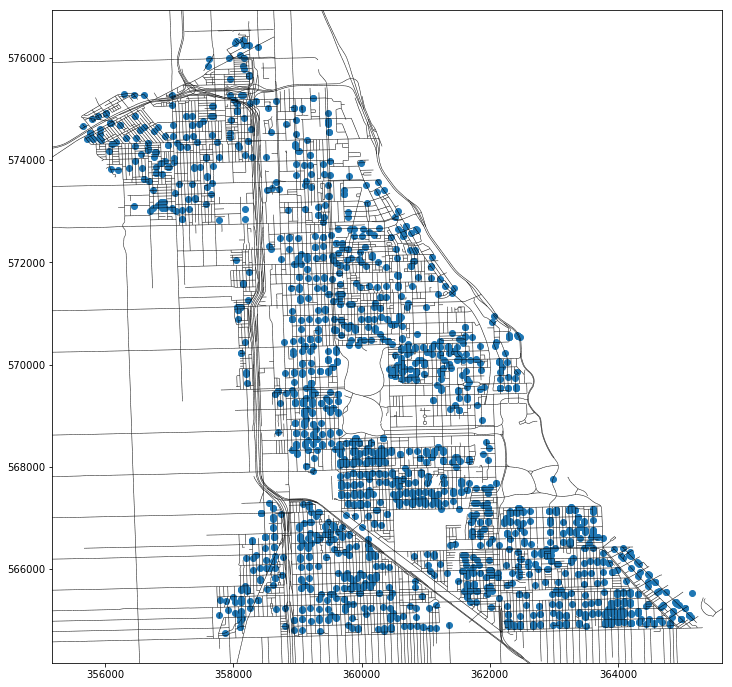

In [10]:
fig, ax = plt.subplots(figsize=(12,12))

lc = matplotlib.collections.LineCollection(graph.as_lines(), color="black", linewidth=0.5)
ax.add_collection(lc)

ax.scatter(timed_points.xcoords, timed_points.ycoords)

xmin, ymin, xmax, ymax = *timed_points.bounding_box.min, *timed_points.bounding_box.max
xd, yd = xmax - xmin, ymax - ymin
ax.set(xlim=(xmin-xd/20, xmax+xd/20), ylim=(ymin-yd/20, ymax+yd/20))
None

[(565000, 567000), (362000, 364000)]

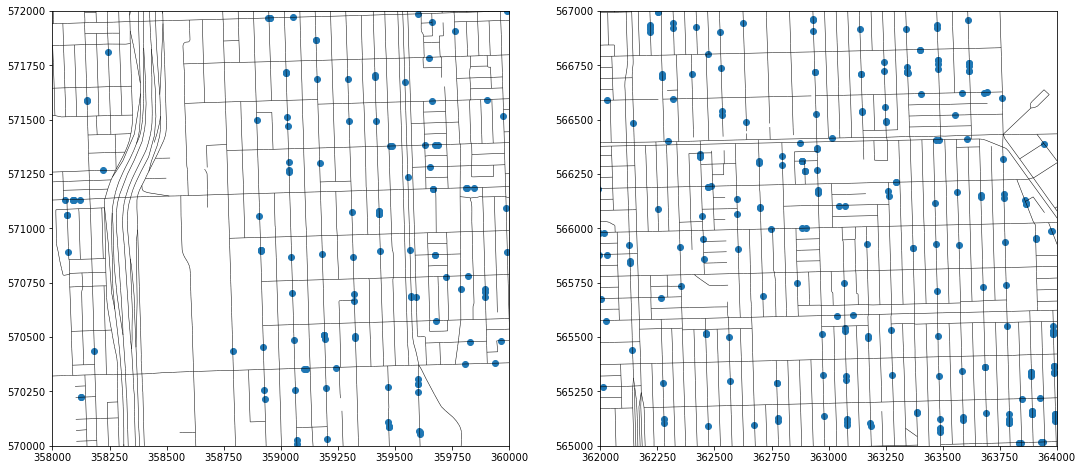

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(18,8))

for ax in axes:
    lc = matplotlib.collections.LineCollection(graph.as_lines(), color="black", linewidth=0.5)
    ax.add_collection(lc)
    ax.scatter(timed_points.xcoords, timed_points.ycoords)

axes[0].set(xlim=[358000, 360000], ylim=[570000, 572000])
axes[1].set(xlim=[362000, 364000], ylim=[565000, 567000])

## Save for later

We'll save using `pickle` for use in other notebooks

In [12]:
import pickle, lzma
with lzma.open("input.pic.xz", "wb") as f:
    pickle.dump(timed_points, f)
with open("input.graph", "wb") as f:
    f.write(graph.dump_bytes())

## With old data

Older data (which is no longer publically available, sadly) is more accurately geocoded.

In [13]:
filename = os.path.join(data_path, "chicago_all_old.csv")
timed_points = open_cp.sources.chicago.load(filename, ["BURGLARY"], type="all")
timed_points.number_data_points

326540

In [14]:
timed_points = open_cp.geometry.intersect_timed_points(timed_points, south_side)
timed_points.number_data_points

46920

In [15]:
with lzma.open("input_old.pic.xz", "wb") as f:
    pickle.dump(timed_points, f)
with open("input_old.graph", "wb") as f:
    f.write(graph.dump_bytes())